In [19]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [20]:
# Generate fake multitemporal images: height, width = 200, 2 channels, 20 temporal acquisitions
rdm_data = np.random.random((200, 200, 2, 20))

# Create targets at various timesteps
rdm_data[50:100, 50:100, :, [1, 4, 7, 11, 14]] = 2
rdm_data[50:100, 0:50, :, [0, 3, 5, 9, 17]] = 2
rdm_data[150:200, 50:100, :, [2, 6, 8, 10, 16, 19]] = 2
rdm_data[150:200, 150:200, :, [0, 6, 15, 17, 18, 19]] = 2

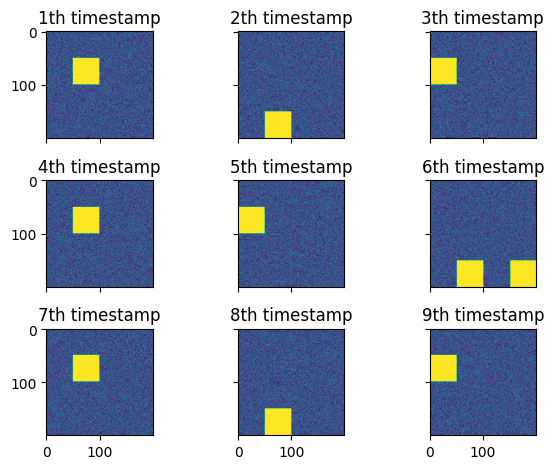

In [ ]:
# Plotting snippets of data
fig, axes = plt.subplots(3, 3, sharex=True, sharey=True, tight_layout=True)
for i, d in enumerate([1, 2, 3, 4, 5, 6, 7, 8, 9]):
    axes[i // 3, i % 3].imshow(rdm_data[:, :, 0, d])
    axes[i // 3, i % 3].set_title(f"{d}th timestamp")
plt.show()

In [ ]:
# Reshape the data to match the expected input shape for spatial autoencoder
# Reorder dimensions to (temporal, channels, height, width) and then flatten the time dimension into the batch size
f_rdm_data = rdm_data.transpose(3, 2, 0, 1)  # (temporal, channels, height, width)
f_rdm_data = f_rdm_data.reshape(-1, 2, 200, 200)  # Flatten temporal into batch size

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader

class SpatialDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert numpy array to torch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Create dataset and dataloader
trainset = SpatialDataset(f_rdm_data)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Check if dataloader works
for batch in trainloader:
    print(batch.shape)  # Print batch shape to verify
    break  # Exit after one batch for verification

torch.Size([20, 2, 200, 200])


In [22]:
# Create dataset and dataloader
trainset = SpatialDataset(f_rdm_data)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)


In [23]:
# Prepare data for training
f_rdm_data = rdm_data.transpose((3, 2, 0, 1))  # Reshape for (batch_size, channels, height, width)
dataset = SpatialDataset(f_rdm_data)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True)

In [24]:
# Define the Spatial Convolutional Autoencoder (CAE)
class SpatialCAE(nn.Module):
    def __init__(self, emb_dim):
        super(SpatialCAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ELU(True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.MaxPool2d(2),
            nn.ELU(True)
        )
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 50 * 50, 128),
            nn.ELU(),
            nn.Linear(128, 64),
            nn.ELU(),
            nn.Linear(64, emb_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(emb_dim, 64),
            nn.ELU(),
            nn.Linear(64, 128),
            nn.ELU(),
            nn.Linear(128, 128 * 50 * 50),
            nn.ELU(),
            nn.Unflatten(1, (128, 50, 50)),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1, stride=2, output_padding=1),
            nn.ELU(True),
            nn.ConvTranspose2d(64, 2, kernel_size=3, padding=1, stride=2, output_padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.head(x)
        x = self.decoder(x)
        return x

In [25]:
# Training setup
device = "cuda" if torch.cuda.is_available() else "cpu"
net = SpatialCAE(emb_dim=3).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# Training loop
epoch_counts = 5
for epoch in range(epoch_counts):
    running_loss = 0.0
    for data in trainloader:
        inputs = data.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epoch_counts}, Loss: {running_loss / len(trainloader):.4f}')

Epoch 1/5, Loss: 0.6334
Epoch 2/5, Loss: 0.3492
Epoch 3/5, Loss: 0.2379
Epoch 4/5, Loss: 0.2048
Epoch 5/5, Loss: 0.1924


In [26]:
# Generating embedding representation
testloader = DataLoader(trainset, batch_size=64, shuffle=False)
stacked_embs = []
for data in testloader:
    inputs = data.to(device)
    encoded = net.encoder(inputs).detach().cpu().numpy()
    stacked_embs.append(encoded)

stacked_embs = np.concatenate(stacked_embs, axis=0)
print(f'Stacked embeddings shape: {stacked_embs.shape}')


Stacked embeddings shape: (20, 128, 50, 50)


In [27]:
# Parameters based on embeddings shape
number_of_images = stacked_embs.shape[0]  # Should be 20
embedding_dim = stacked_embs.shape[1]  # Should be 128
height, width = stacked_embs.shape[2], stacked_embs.shape[3]  # Should be 50, 50

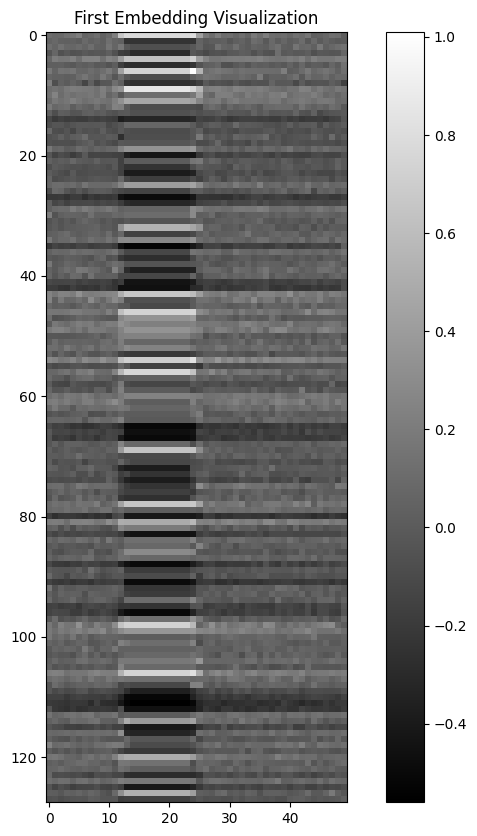

In [28]:
# Option 2: Visualize a specific slice (e.g., the first embedding's first channel)
plt.figure(figsize=(10, 10))
plt.imshow(stacked_embs[0, :, :, 0], cmap='gray')  # Visualize the first channel of the first embedding
plt.title('First Embedding Visualization')
plt.colorbar()
plt.show()

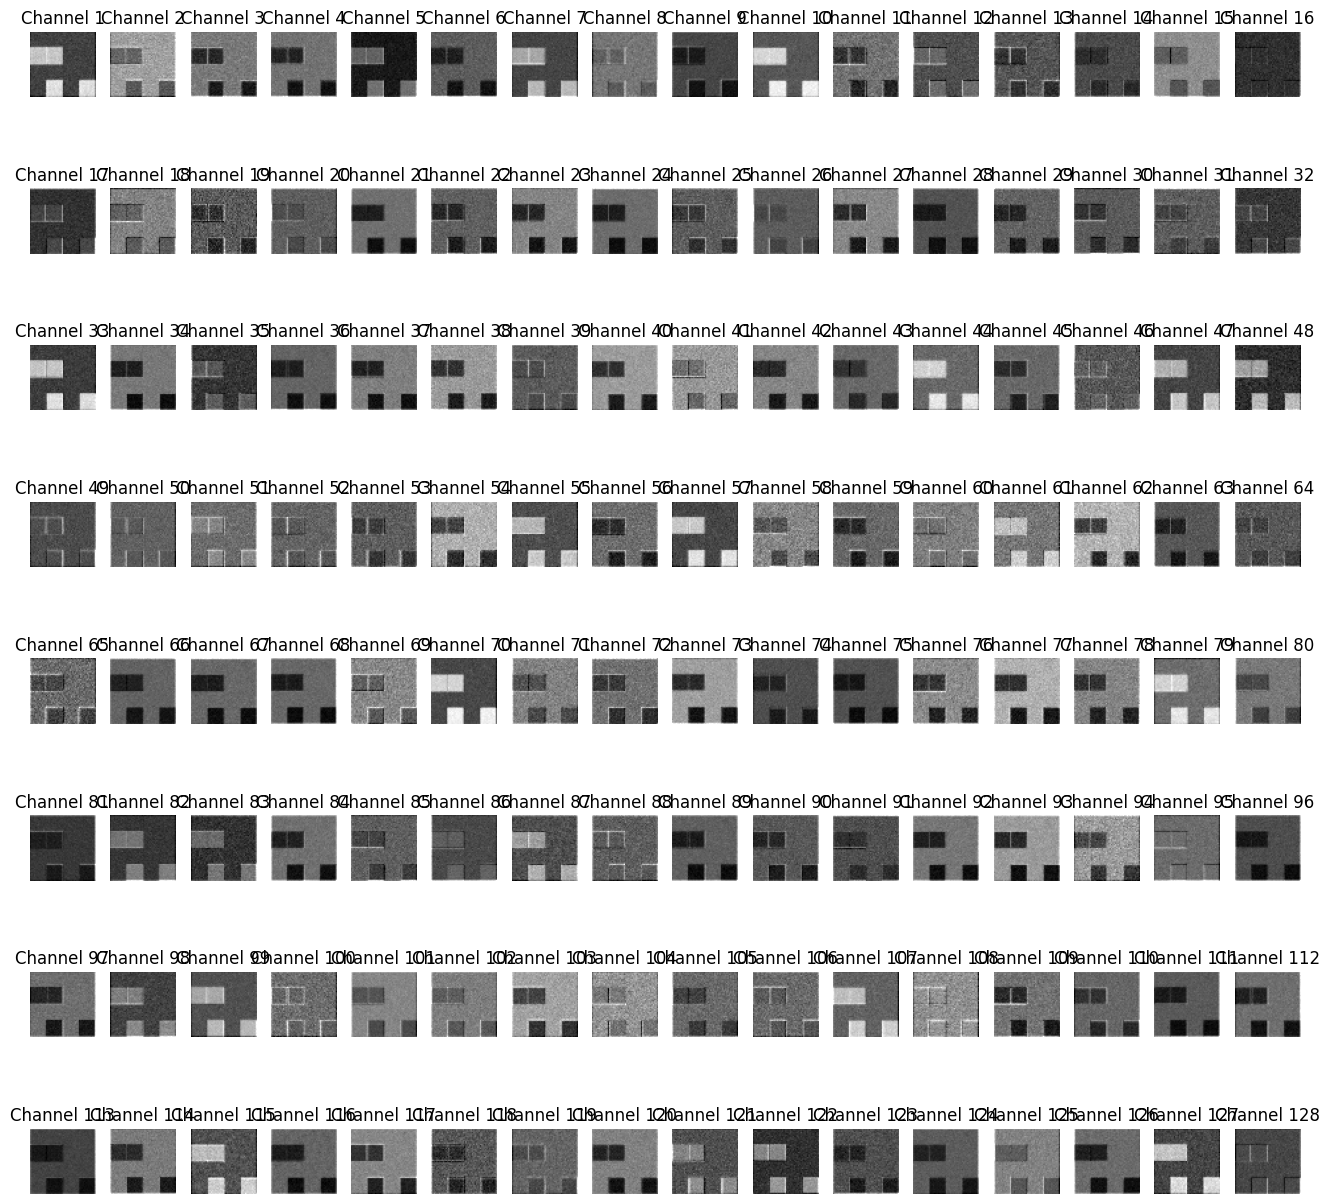

In [32]:
# Option 1: Visualize the mean of all embeddings across the batch dimension for each channel
mean_embedding = np.mean(stacked_embs, axis=0)  # Shape: (128, 50, 50)
plt.figure(figsize=(13,13))
for i in range(embedding_dim):
    plt.subplot(8, 16, i + 1)  # Adjust subplot dimensions if necessary
    plt.imshow(mean_embedding[i, :, :], cmap='gray')
    plt.title(f'Channel {i + 1}')
    plt.axis('off')
plt.tight_layout()
plt.show()